In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

#### **Part 1: Data Cleaning**

**Read Raw Data**

In [2]:
df = pd.read_json('cohort.2024-10-17 (2).json')
df.head()

,summary,primary_site,disease_type,case_id,submitter_id,project,diagnoses,demographic,submitter_slide_ids
0,"{'file_count': 23, 'experimental_strategies': ...",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,58771370-5082-485e-ac68-13edfbd9ef0c,TARGET-20-PAWKJC,"{'project_id': 'TARGET-AML', 'program': {'name...",[{'age_at_diagnosis': 3551}],"{'race': 'asian', 'gender': 'male', 'ethnicity...",NaN
1,"{'file_count': 11, 'experimental_strategies': ...",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28da5b52-29ed-4817-a678-9206c5164da0,TARGET-20-PAUNLX,"{'project_id': 'TARGET-AML', 'program': {'name...",[{'age_at_diagnosis': 4780}],"{'race': 'white', 'gender': 'female', 'ethnici...",NaN
2,"{'file_count': 9, 'experimental_strategies': [...",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28dae019-4d93-42bf-9bb3-8e6e21bc1d29,TARGET-20-D7-EC-GFP2,"{'project_id': 'TARGET-AML', 'program': {'name...",NaN,NaN,NaN
3,"{'file_count': 12, 'experimental_strategies': ...",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28f7e68c-e0ab-4fb0-b835-2e506cb0012d,TARGET-20-KasumiAZAD11,"{'project_id': 'TARGET-AML', 'program': {'name...",NaN,NaN,NaN
4,"{'file_count': 14, 'experimental_strategies': ...",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28ffdfb9-f051-4424-ad35-e6633e6bf42e,TARGET-20-PAVHML,"{'project_id': 'TARGET-AML', 'program': {'name...",[{'age_at_diagnosis': 492}],"{'race': 'white', 'gender': 'female', 'ethnici...",NaN


In [3]:
# Normalize each column
df_summary = pd.json_normalize(df['summary'])
df_project = pd.json_normalize(df['project'])
df_demographic = pd.json_normalize(df['demographic'])

# Concatenate the new columns with the original df_cleanFrame
df_clean = pd.concat([df, df_summary, df_project, df_demographic], axis=1)

# Drop the original columns if no longer needed
df_clean.drop(columns=['summary', 'project', 'demographic'], inplace=True)

In [4]:
# Extracting 'experimental_strategy' into a new column with list comprehension
df_clean['experimental_strategy'] = df_clean['experimental_strategies'].apply(
    lambda x: [d["experimental_strategy"] for d in x] if isinstance(x, list) else []
)

df_clean['age_at_diagnosis'] = df_clean['diagnoses'].apply(
    lambda x: x[0]["age_at_diagnosis"] if isinstance(x, list) and x else None
)

In [5]:
# Drop the original 'experimental_strategies' column if no longer needed
df_clean.drop(columns=['experimental_strategies', 'diagnoses'], inplace=True)

# Reorder the columns so that 'file_count' is first and 'experimental_strategy' is second
cols = ['file_count', 'experimental_strategy'] + [col for col in df_clean.columns if col not in ['file_count', 'experimental_strategy']]
df_clean = df_clean.reindex(columns=cols)

df_clean.head()

,file_count,experimental_strategy,primary_site,disease_type,case_id,submitter_id,submitter_slide_ids,project_id,program.name,race,gender,ethnicity,vital_status,days_to_death,age_at_diagnosis
0,23,"[RNA-Seq, miRNA-Seq]",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,58771370-5082-485e-ac68-13edfbd9ef0c,TARGET-20-PAWKJC,NaN,TARGET-AML,TARGET,asian,male,not hispanic or latino,Dead,939.0,3551.0
1,11,[RNA-Seq],Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28da5b52-29ed-4817-a678-9206c5164da0,TARGET-20-PAUNLX,NaN,TARGET-AML,TARGET,white,female,hispanic or latino,Alive,NaN,4780.0
2,9,[RNA-Seq],Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28dae019-4d93-42bf-9bb3-8e6e21bc1d29,TARGET-20-D7-EC-GFP2,NaN,TARGET-AML,TARGET,NaN,NaN,NaN,NaN,NaN,NaN
3,12,"[RNA-Seq, miRNA-Seq]",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28f7e68c-e0ab-4fb0-b835-2e506cb0012d,TARGET-20-KasumiAZAD11,NaN,TARGET-AML,TARGET,NaN,NaN,NaN,NaN,NaN,NaN
4,14,"[RNA-Seq, miRNA-Seq]",Hematopoietic and reticuloendothelial systems,Myeloid Leukemias,28ffdfb9-f051-4424-ad35-e6633e6bf42e,TARGET-20-PAVHML,NaN,TARGET-AML,TARGET,white,female,not hispanic or latino,Alive,NaN,492.0


In [6]:
unique_strategies = set()

for strategies in df_clean['experimental_strategy']:
    # Check if the entry is already a list
    if isinstance(strategies, str):
        strategies = eval(strategies)  # Convert string to list if it's a string representation of a list
    # Now strategies should be a list; iterate through it to add each strategy
    for strategy in strategies:
        unique_strategies.add(strategy)

In [7]:
# Create a new column for each unique strategy
for strategy in unique_strategies:
    df_clean[f'strategy_{strategy}'] = df_clean['experimental_strategy'].apply(
        lambda x: int(strategy in (ast.literal_eval(x) if isinstance(x, str) else x))
    )

In [8]:
# Count the number of strategies for each entry
df_clean['num_strategies'] = df_clean['experimental_strategy'].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)

In [9]:
# Create a new column 'has_strategies' that is 1 if 'num_strategies' is greater than 0, and 0 otherwise
df_clean['has_strategies'] = df_clean['num_strategies'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
# Drop meaningless columns
drop_columns = ['submitter_id', 'submitter_slide_ids','case_id','project_id','experimental_strategy']
df_clean.drop(columns=drop_columns, inplace=True)

In [11]:
# Replace specified entries in 'race' column with 'unknown'
df_clean['race'] = df_clean['race'].replace(
    ['unknown', 'Unknown', 'other', 'not reported', 'not allowed to collect'], 'unknown'
)

# Replace specified entries in 'gender' column with 'unknown'
df_clean['gender'] = df_clean['gender'].replace(
    ['unknown', 'not reported', 'unspecified'], 'unknown'
)

# Replace specified entries in 'ethnicity' column with 'unknown'
df_clean['ethnicity'] = df_clean['ethnicity'].replace(
    ['unknown', 'Unknown' 'not reported'], 'unknown'
)

# Replace specified entries in 'vital_status' column with 'unknown'
df_clean['vital_status'] = df_clean['vital_status'].replace(
    ['Unknown' 'Not Reported'], 'unknown'
)

In [12]:
# Save the cleaned df_clean to csv
#df_clean.to_csv('cohort.2024-10-17_cleaned_v4.csv', index=False)

#### **Part 2: Data Exploration**

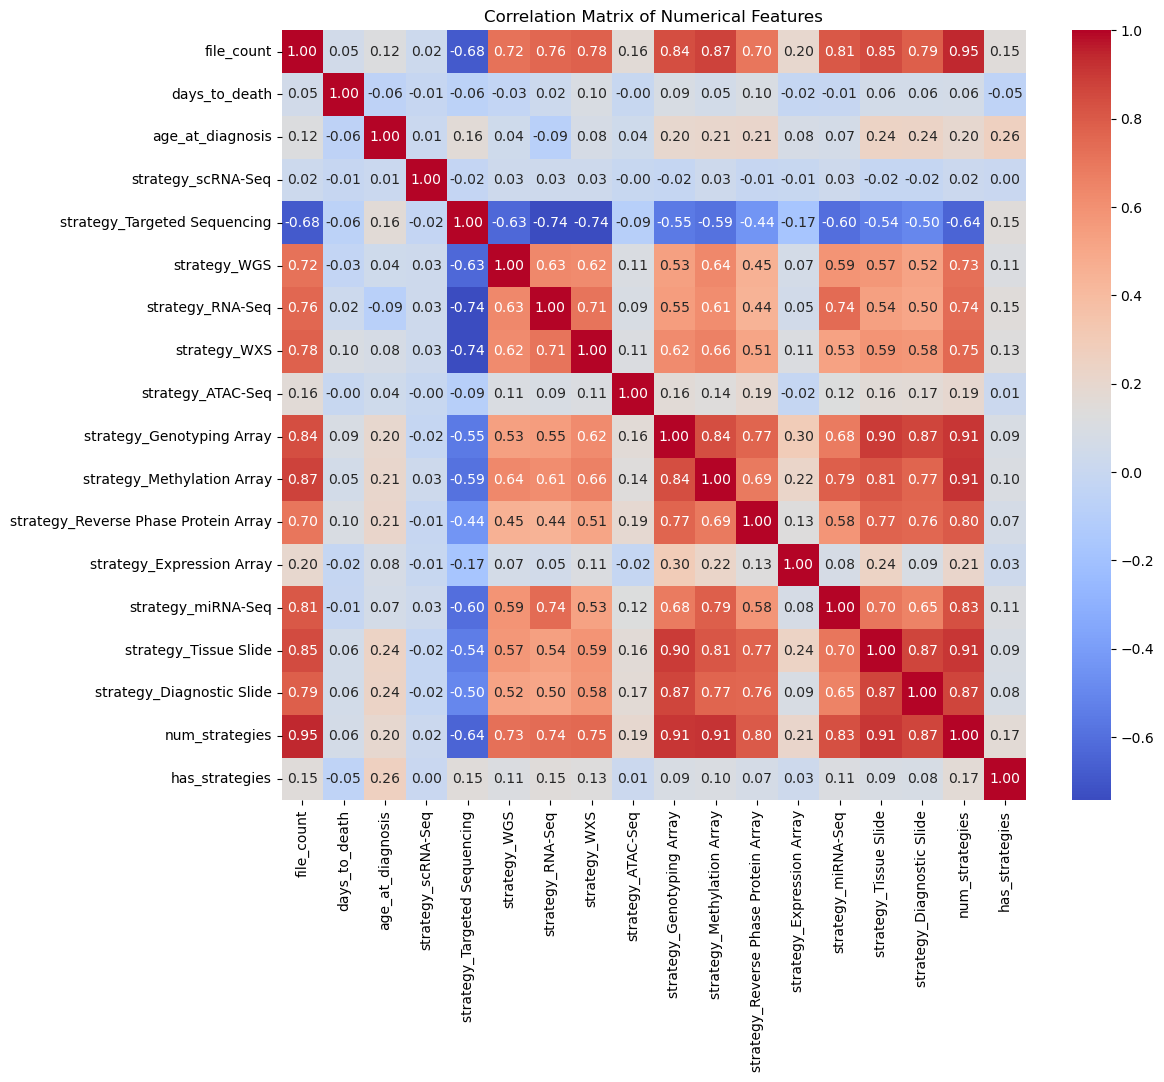

In [13]:
# Select numerical columns for correlation matrix
numerical_cols = df_clean.select_dtypes(include=[np.number]).columns
correlation_matrix = df_clean[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

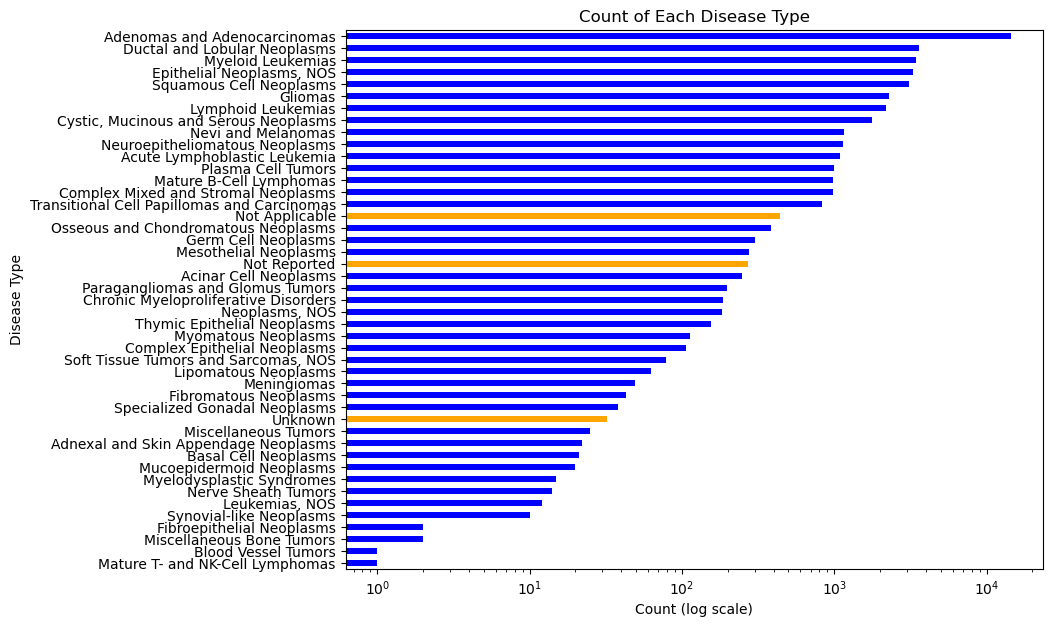

In [14]:
#Distribution of Disease Types (Target Variable)
disease_counts = df_clean['disease_type'].value_counts()

colors = ['orange' if disease in ["Not Applicable", "Unknown", "Not Reported"] else 'blue' for disease in disease_counts.index]

plt.figure(figsize=(9, 7))
disease_counts.plot(kind='barh', color=colors)
plt.xscale('log') 
plt.xlabel('Count (log scale)')  #using log scale since the classes are highly imbalanced
plt.ylabel('Disease Type')
plt.title('Count of Each Disease Type')
plt.gca().invert_yaxis() #highest count on the top
plt.show()

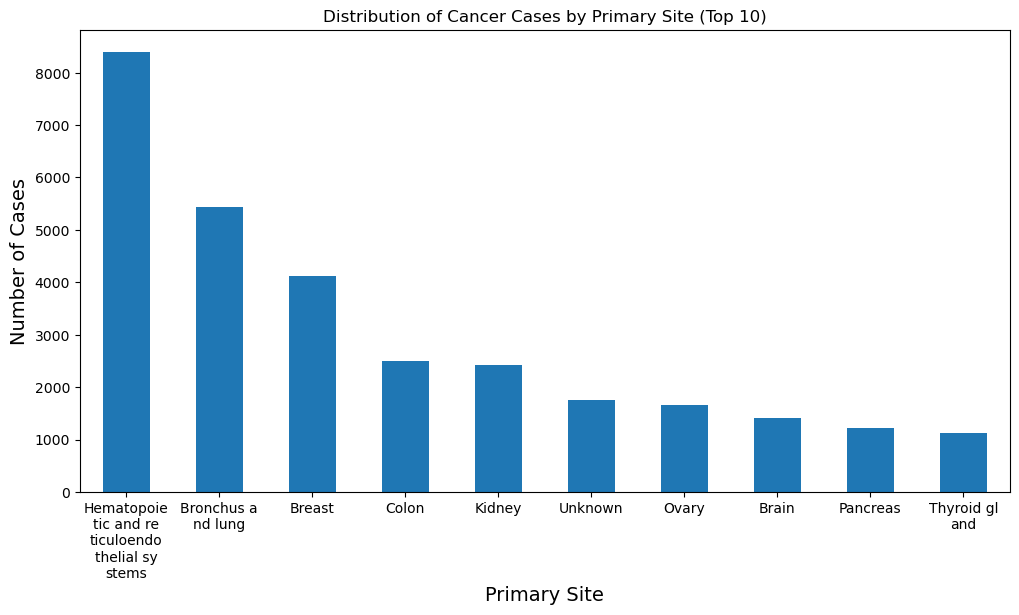

In [15]:
# Distribution of Cancer Types by Primary Site
# Limit the number of characters per line in x labels
# Function to add line breaks to labels
def add_line_breaks(label, max_length):
    return '\n'.join([label[i:i+max_length] for i in range(0, len(label), max_length)])

max_label_length = 10
labels_with_line_breaks = [add_line_breaks(label, max_label_length) for label in df_clean['primary_site'].value_counts().head(10).index]

plt.figure(figsize=(12, 6))
df_clean['primary_site'].value_counts().head(10).plot(kind='bar')
plt.title("Distribution of Cancer Cases by Primary Site (Top 10)")
plt.xlabel("Primary Site", size=14)
plt.ylabel("Number of Cases", size=14)
plt.xticks(ticks=range(10), labels=labels_with_line_breaks, rotation=0)
plt.show()

<Figure size 1000x600 with 0 Axes>

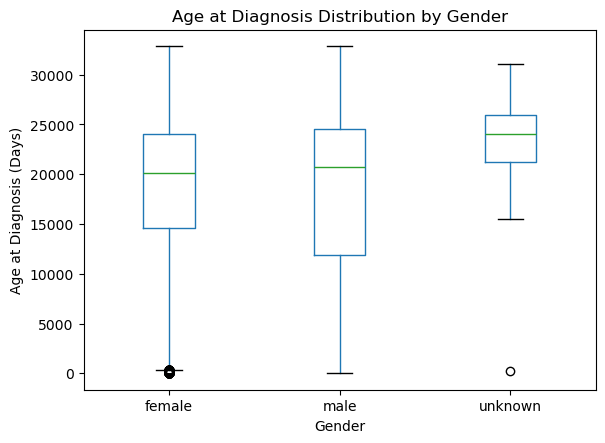

In [16]:
# Age at Diagnosis Distribution by Gender
plt.figure(figsize=(10, 6))
df_clean[df_clean['age_at_diagnosis'].notnull()].boxplot(column='age_at_diagnosis', by='gender', grid=False)
plt.title("Age at Diagnosis Distribution by Gender")
plt.suptitle("")
plt.xlabel("Gender")
plt.ylabel("Age at Diagnosis (Days)")
plt.show()

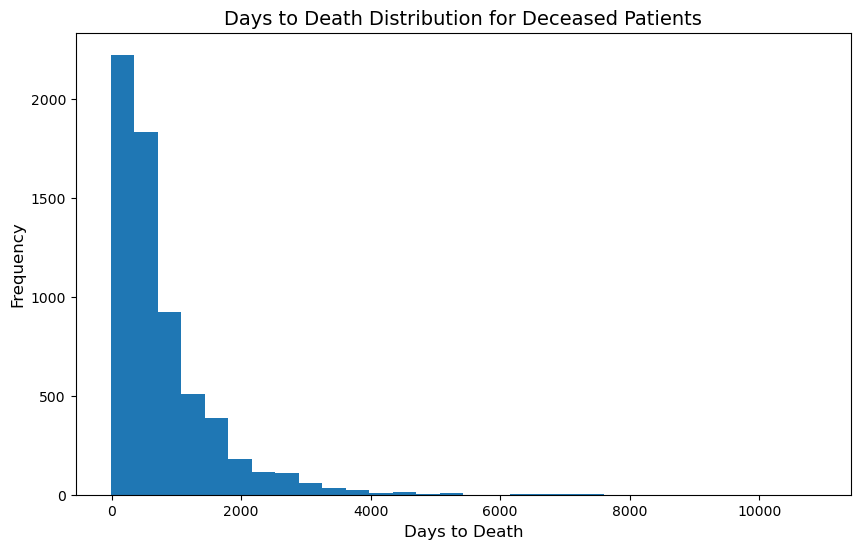

In [17]:
# Survival Analysis - Vital Status and Days to Death Distribution
plt.figure(figsize=(10, 6))
df_clean[df_clean['days_to_death'].notnull() & (df_clean['vital_status'] == 'Dead')]['days_to_death'].plot(kind='hist', bins=30)
plt.title("Days to Death Distribution for Deceased Patients", size=14)
plt.xlabel("Days to Death", size=12)
plt.ylabel("Frequency", size=12)
plt.show()

<Figure size 1200x800 with 0 Axes>

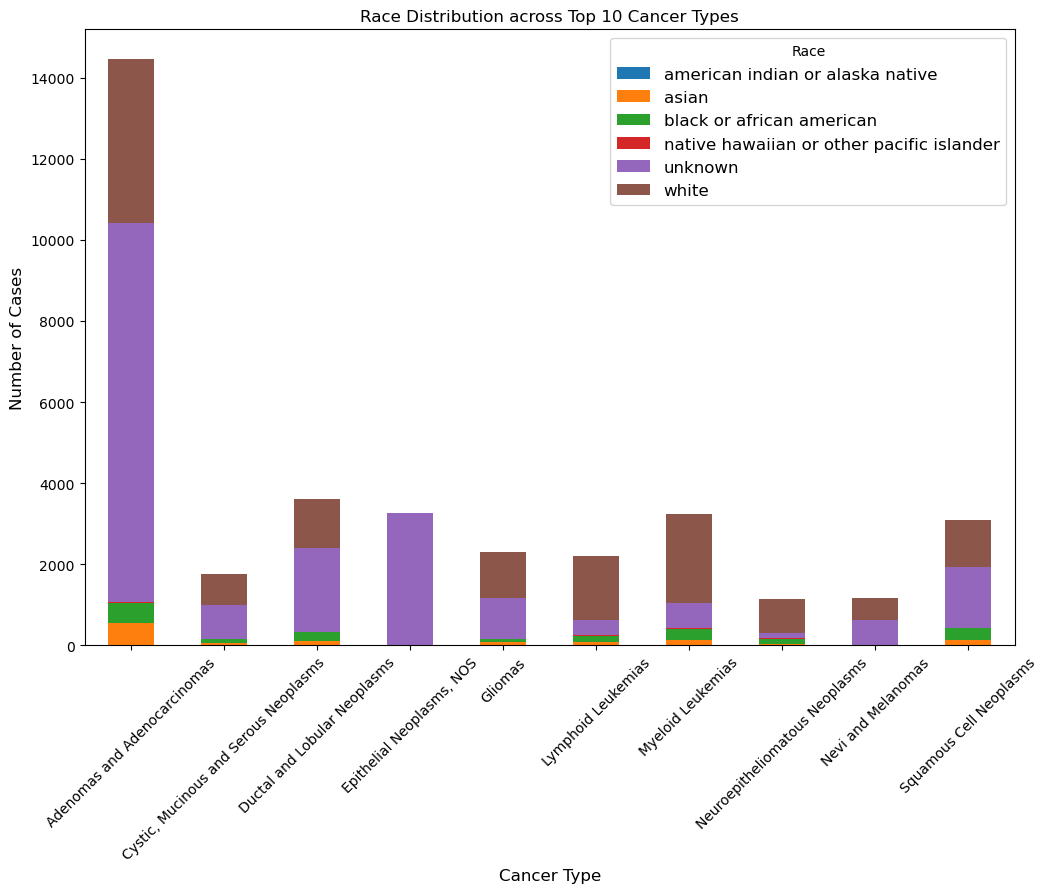

In [18]:
# Race Distribution across Different Cancer Types
plt.figure(figsize=(12, 8))
top_cancer_types = df_clean['disease_type'].value_counts().nlargest(10).index
race_df_clean = df_clean[df_clean['disease_type'].isin(top_cancer_types)].groupby(['disease_type', 'race']).size().unstack()
race_df_clean.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title("Race Distribution across Top 10 Cancer Types")
plt.xlabel("Cancer Type", size=12)
plt.ylabel("Number of Cases", size=12)
plt.legend(title='Race', prop={'size': 12})
plt.xticks(rotation=45, size=10)
plt.show()

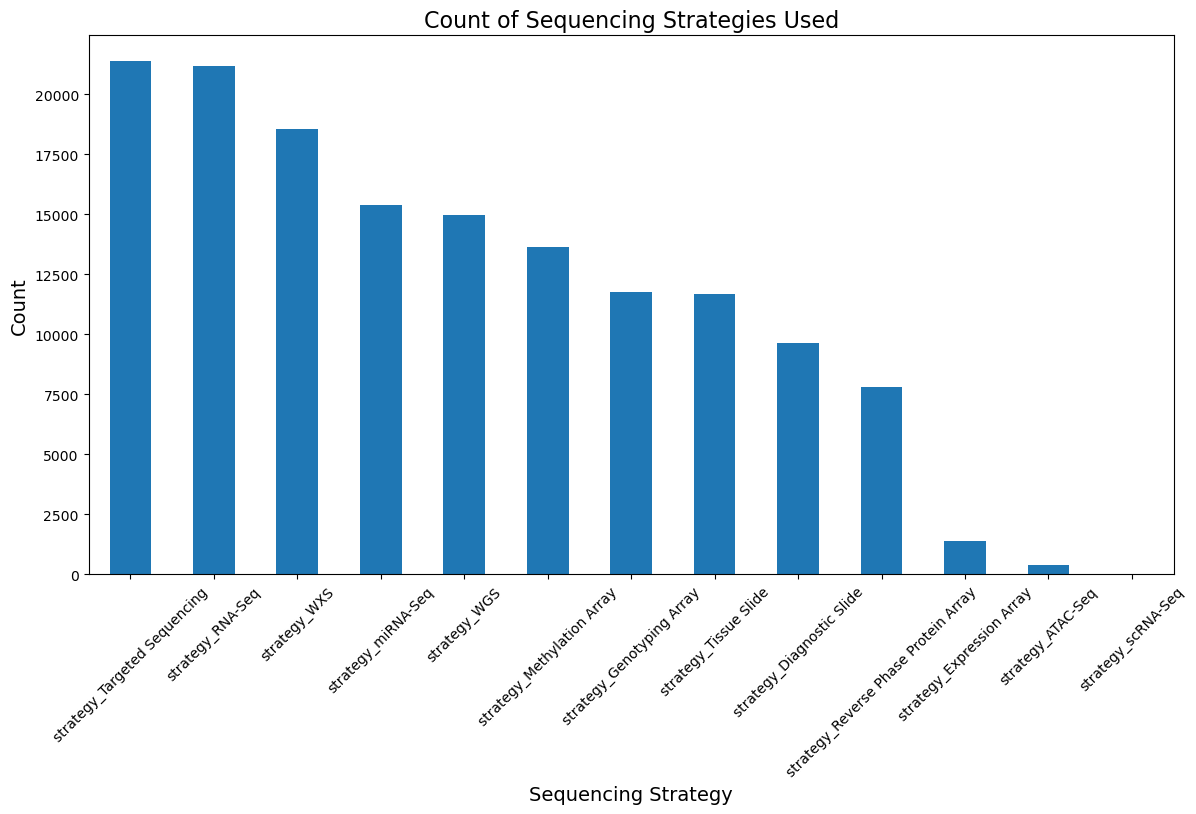

In [19]:
# Count of Sequencing Strategies Used
strategies_columns = [col for col in df_clean.columns if col.startswith('strategy_')]
strategies_counts = df_clean[strategies_columns].sum().sort_values(ascending=False)
plt.figure(figsize=(14, 7))
strategies_counts.plot(kind='bar')
plt.title("Count of Sequencing Strategies Used", size=16)
plt.xlabel("Sequencing Strategy", size=14)
plt.ylabel("Count", size=14)
plt.xticks(rotation=45)
plt.show()

#### **Part 3: Model Implementation**

In [20]:
df_clean = pd.read_csv('cohort.2024-10-17_cleaned_v4.csv')

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
warnings.filterwarnings('ignore')

In [22]:
df_clean.count()

file_count                              44736
primary_site                            44387
disease_type                            44727
program.name                            44736
race                                    44171
gender                                  44171
ethnicity                               44171
vital_status                            44171
days_to_death                            6469
age_at_diagnosis                        42288
strategy_WXS                            44736
strategy_miRNA-Seq                      44736
strategy_Reverse Phase Protein Array    44736
strategy_Methylation Array              44736
strategy_Expression Array               44736
strategy_Diagnostic Slide               44736
strategy_ATAC-Seq                       44736
strategy_Tissue Slide                   44736
strategy_scRNA-Seq                      44736
strategy_WGS                            44736
strategy_RNA-Seq                        44736
strategy_Genotyping Array         

In [23]:
df_clean.isna().sum()

file_count                                  0
primary_site                              349
disease_type                                9
program.name                                0
race                                      565
gender                                    565
ethnicity                                 565
vital_status                              565
days_to_death                           38267
age_at_diagnosis                         2448
strategy_WXS                                0
strategy_miRNA-Seq                          0
strategy_Reverse Phase Protein Array        0
strategy_Methylation Array                  0
strategy_Expression Array                   0
strategy_Diagnostic Slide                   0
strategy_ATAC-Seq                           0
strategy_Tissue Slide                       0
strategy_scRNA-Seq                          0
strategy_WGS                                0
strategy_RNA-Seq                            0
strategy_Genotyping Array         

In [24]:
# Drop 'days_to_death' column as there are too many missing values
df_clean.drop(columns=['days_to_death'], inplace=True)

In [25]:
categorical_columns = ['primary_site', 'program.name',
                       'race', 'gender', 'ethnicity', 'vital_status']

for col in categorical_columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes

label_encoder = LabelEncoder()
df_clean['disease_type'] = label_encoder.fit_transform(df_clean['disease_type'])

class_counts = pd.Series(df_clean['disease_type']).value_counts()
valid_classes = class_counts[class_counts >= 2].index
filtered_df_clean = df_clean[df_clean['disease_type'].isin(valid_classes)]

filtered_df_clean['disease_type'] = LabelEncoder().fit_transform(filtered_df_clean['disease_type'])

In [26]:
X = filtered_df_clean.drop(columns=['disease_type'])
y = filtered_df_clean['disease_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
X_train.head()

,file_count,primary_site,program.name,race,gender,ethnicity,vital_status,age_at_diagnosis,strategy_WXS,strategy_miRNA-Seq,...,strategy_Diagnostic Slide,strategy_ATAC-Seq,strategy_Tissue Slide,strategy_scRNA-Seq,strategy_WGS,strategy_RNA-Seq,strategy_Genotyping Array,strategy_Targeted Sequencing,num_strategies,has_strategies
23697,5,57,8,4,1,3,2,9812.0,0,0,...,0,0,0,0,0,0,0,1,1,1
42239,50,20,17,5,1,1,1,590.0,0,1,...,0,0,0,0,1,1,0,1,5,1
21824,5,67,8,4,0,3,2,20838.0,0,0,...,0,0,0,0,0,0,0,1,1,1
5578,4,22,17,2,0,2,0,1439.0,0,0,...,0,0,0,0,0,0,0,1,1,1
10407,75,7,18,5,0,3,0,18494.0,1,1,...,1,0,1,0,1,1,1,0,9,1


In [28]:
y_train.head()

23697    14
42239    25
21824    38
5578      7
10407    14
Name: disease_type, dtype: int64

**Logistic Regression**

In [29]:
from sklearn.impute import SimpleImputer

# Impute missing values with the mean of the column
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train_imputed, y_train)
y_pred_logistic = logistic_model.predict(X_test_imputed)

# Convert the predicted labels back to their original names
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_logistic_original = label_encoder.inverse_transform(y_pred_logistic)

print("\nLogistic Regression Classification Report:\n", classification_report(y_test_original, y_pred_logistic_original))


Logistic Regression Classification Report:
                                              precision    recall  f1-score   support

                      Acinar Cell Neoplasms       0.00      0.00      0.00        50
               Acute Lymphoblastic Leukemia       0.00      0.00      0.00       217
               Adenomas and Adenocarcinomas       0.39      0.97      0.55      2907
       Adnexal and Skin Appendage Neoplasms       0.00      0.00      0.00         4
                       Basal Cell Neoplasms       0.00      0.00      0.00         4
                        Blood Vessel Tumors       0.00      0.00      0.00        37
       Chronic Myeloproliferative Disorders       0.00      0.00      0.00        21
               Complex Epithelial Neoplasms       0.00      0.00      0.00       195
        Complex Mixed and Stromal Neoplasms       0.00      0.00      0.00       355
      Cystic, Mucinous and Serous Neoplasms       0.00      0.00      0.00       721
               Duct

### Evaluation Metrics

In [30]:
logistic_accuracy = accuracy_score(y_test_original, y_pred_logistic_original)
logistic_f1 = f1_score(y_test_original, y_pred_logistic_original, average='weighted')

print(f"Accuracy of logistic regression model: {logistic_accuracy}")
print(f"F1 Score of logistic regression model: {logistic_f1}")

Accuracy of logistic regression model: 0.36693863864982673
F1 Score of logistic regression model: 0.22096567954931118


### Random Forest

In [31]:
rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring='accuracy', verbose=1)
grid_search_rf.fit(X_train_imputed, y_train)

best_rf_model = grid_search_rf.best_estimator_

y_pred_rf = best_rf_model.predict(X_test_imputed)

y_pred_rf_original = label_encoder.inverse_transform(y_pred_rf)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)
print("\nRandom Forest Classification Report:\n", classification_report(y_test_original, y_pred_rf_original))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters for Random Forest: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Random Forest Classification Report:
                                              precision    recall  f1-score   support

                      Acinar Cell Neoplasms       0.00      0.00      0.00        50
               Acute Lymphoblastic Leukemia       0.74      1.00      0.85       217
               Adenomas and Adenocarcinomas       0.57      0.98      0.72      2907
       Adnexal and Skin Appendage Neoplasms       0.00      0.00      0.00         4
                       Basal Cell Neoplasms       0.00      0.00      0.00         4
                        Blood Vessel Tumors       1.00      0.65      0.79        37
       Chronic Myeloproliferative Disorders       0.00      0.00      0.00        21
               Complex Epithelial Neoplasms       1.00      0.79      0.88       195
        Compl

### Evaluation Metrics

In [32]:
accuracy_rf = accuracy_score(y_test_original, y_pred_rf_original)
f1_rf_weighted = f1_score(y_test_original, y_pred_rf_original, average='weighted')

print(f"Random Forest Test Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Test F1 Score: {f1_rf_weighted:.4f}")

Random Forest Test Accuracy: 0.6895
Random Forest Test F1 Score: 0.6210


### XGBoost

In [33]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search_xgb = GridSearchCV(xgb_model, param_grid, cv=3, scoring='accuracy', verbose=1)
grid_search_xgb.fit(X_train_imputed, y_train)

best_xgb_model = grid_search_xgb.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test_imputed)

y_pred_xgb_original = label_encoder.inverse_transform(y_pred_xgb)

# Print the best parameters and classification report with original disease_type names
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)
print("\nXGBoost Classification Report:\n", classification_report(y_test_original, y_pred_xgb_original))

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 150}

XGBoost Classification Report:
                                              precision    recall  f1-score   support

                      Acinar Cell Neoplasms       0.85      0.78      0.81        50
               Acute Lymphoblastic Leukemia       0.74      0.98      0.84       217
               Adenomas and Adenocarcinomas       0.81      0.95      0.87      2907
       Adnexal and Skin Appendage Neoplasms       0.00      0.00      0.00         4
                       Basal Cell Neoplasms       0.00      0.00      0.00         4
                        Blood Vessel Tumors       1.00      0.97      0.99        37
       Chronic Myeloproliferative Disorders       0.00      0.00      0.00        21
               Complex Epithelial Neoplasms       0.93      0.88      0.91       195
        Complex Mixed and Stromal Neoplasms       0

### Ealuation Metrics

In [34]:
accuracy_xgb = accuracy_score(y_test_original, y_pred_xgb_original)
f1_xgb = f1_score(y_test_original, y_pred_xgb_original, average='weighted')

print(f"XGBoost Test Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Test F1 Score: {f1_xgb:.4f}")

XGBoost Test Accuracy: 0.8383
XGBoost Test F1 Score: 0.8189
